In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

import sys
from pyprojroot import here
sys.path.append("../..") 
# from laos_gggi.statistics import get_distance_to_rivers

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr

from laos_gggi.replication_data import create_replication_data
from laos_gggi.plotting import plotting_function_damages 
from laos_gggi.model import add_data
from laos_gggi.plotting import configure_plot_style

from laos_gggi.sample import sample_or_load
from laos_gggi.transformers import Standardize


In [3]:
# Set random seed
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [4]:
# Configure plot style
configure_plot_style()

# Importing and cleaning data

In [5]:
damage_df = create_replication_data()
damage_df = damage_df.query('Total_Damage_Adjusted_hydro_millions >0 ')


In [6]:
features =  ['population', 'ln_population_density', 'ln_population_density_squared' ,'ln_gdp_pc', 'square_ln_gdp_pc',
       'dev_from_trend_ocean_temp', 'co2', 'precip_deviation']

In [7]:
# Standardize data
transformer_ = Standardize().fit(damage_df)

damage_df_stand = transformer_.transform(damage_df)

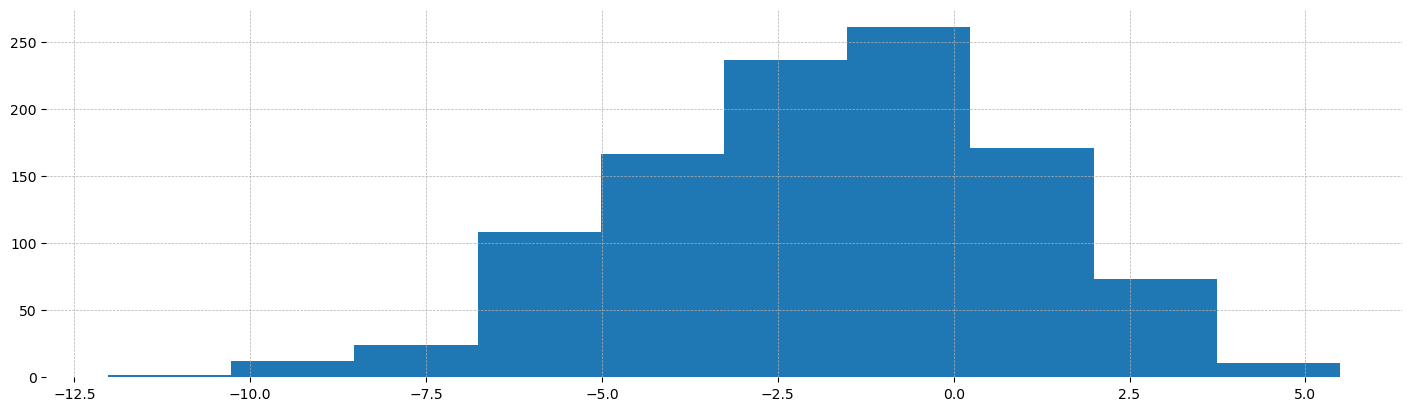

In [8]:
damage_df["ln_damage_millions"].hist();

In [9]:
# Save damage_df_stand
damage_df_stand.to_csv(here("data/damage_df_stand.csv"))

# Damage model

In [10]:
# Define stand features
features_stand = [x + "__standardized" for x in features]

ISO_2_idx, ISO_2 =  pd.factorize(damage_df_stand["ISO"])
coords_damage = {
    'ISO':ISO_2,
    'obs_idx':damage_df_stand.index,
    'feature': features_stand
        }    

xr_idx_damage = xr.Coordinates.from_pandas_multiindex(damage_df_stand.set_index(['ISO', 'year']).index, 'obs_idx')

In [11]:
#Simple Damages model
with pm.Model(coords=coords_damage) as damages_model:
    #Declare data
    X, Y= add_data(features= coords_damage["feature"] ,  target = "ln_damage_millions", df = damage_df_stand,
                  dims = ("obs_idx", "feature" ))
    
    #Country effectz
    country_effect = pm.Normal("country_effect", mu = 0, sigma =3, dims = ["ISO"])

    #betas_damage
    betas_damage = pm.Normal("betas_damage", mu = 0, sigma = 3, dims = ["feature"])

    #Model mu
    mu = country_effect[ISO_2_idx] + X @ betas_damage

    #Sigma
    sigma = pm.Exponential('sigma', 0.1)

    ln_damage_millions = pm.Normal("ln_damage_millions", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])
    
    damage_millions = pm.Deterministic('damage_millions', pt.exp(ln_damage_millions), dims = ["obs_idx"])

In [12]:
#Sampling
with damages_model:
    damage_idata =sample_or_load(
            fp="damages_model.idata",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
               "target_accept": 0.9,
                "draws": 1000,
            })

    damage_idata = damage_idata.assign_coords(xr_idx_damage)

In [13]:
az.summary(damage_idata, ["~country_effect", "~ln_damage_millions", "~damage_millions"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['ln_damage_millions'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas_damage[population__standardized],0.194,0.801,-1.187,1.587,0.282,0.207,8.0,10.0,5.10
betas_damage[ln_population_density__standardized],0.209,1.349,-1.661,2.016,0.475,0.349,8.0,10.0,6.56
betas_damage[ln_population_density_squared__standardized],-0.492,1.035,-1.882,1.204,0.364,0.268,8.0,10.0,6.49
betas_damage[ln_gdp_pc__standardized],0.467,1.433,-1.572,2.306,0.505,0.371,8.0,11.0,5.21
betas_damage[square_ln_gdp_pc__standardized],0.246,0.722,-0.629,1.402,0.254,0.187,8.0,16.0,5.20
betas_damage[dev_from_trend_ocean_temp__standardized],0.364,0.658,-0.814,1.401,0.232,0.170,8.0,10.0,5.30
betas_damage[co2__standardized],0.467,0.750,-0.878,1.535,0.264,0.194,8.0,10.0,5.38
betas_damage[precip_deviation__standardized],-0.555,1.018,-1.842,1.286,0.359,0.263,8.0,10.0,5.25
sigma,1.918,0.851,0.408,2.800,0.300,0.220,9.0,10.0,4.34
sigma_log__,0.485,0.662,-0.896,1.030,0.233,0.171,9.0,10.0,4.34


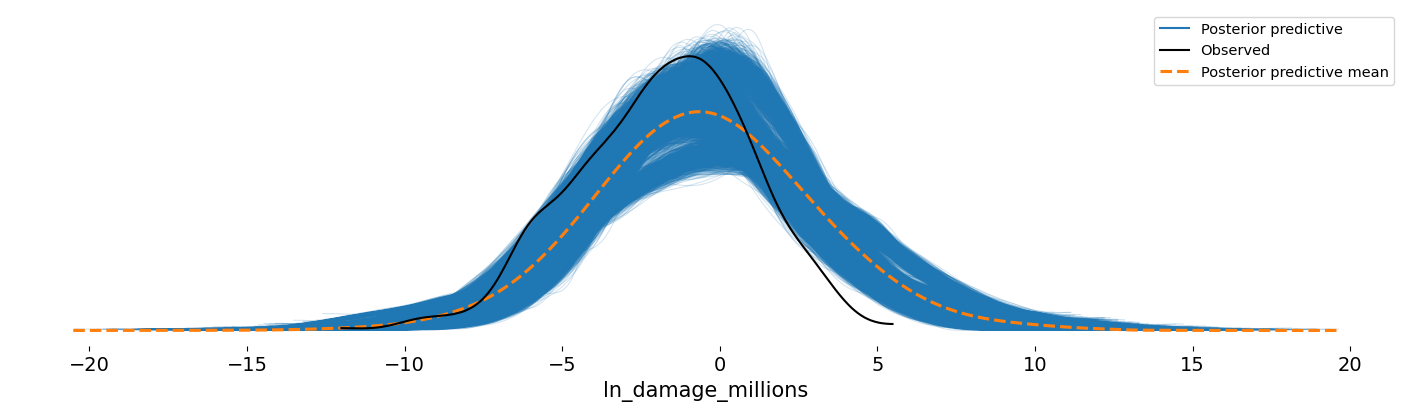

In [14]:
az.plot_ppc(damage_idata);

# Predictions

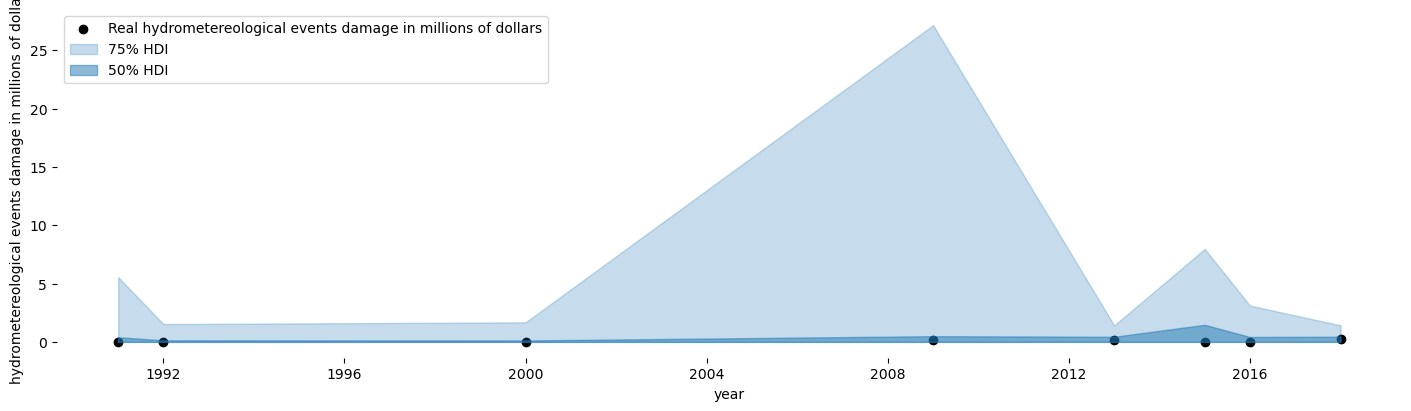

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotting_function_damages(idata =damage_idata , 
                      country = "LAO",
                      df = damage_df_stand ,
                     target_variable= "damage_millions")

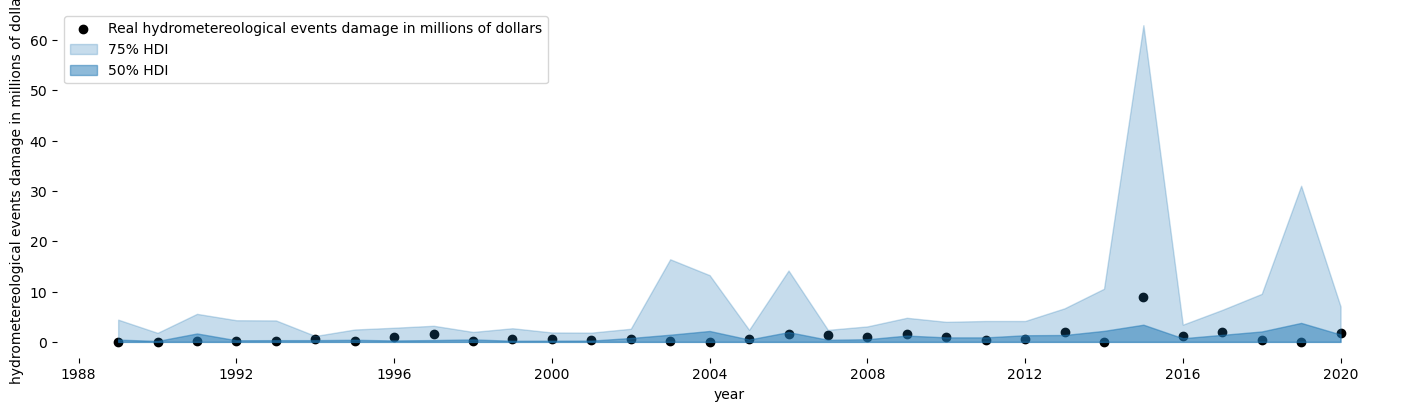

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotting_function_damages(idata =damage_idata , 
                      country = "VNM",
                      df = damage_df_stand ,
                     target_variable= "damage_millions")